# Laboratorio 7 - Linear Programming
## <font size=4> *CC2017 - Modelación y Simulación*, 2024 </font>
## <font size=3 color='gray'> Samuel Chamale, Adrian Rodriguez y Daniel Gómez</font>

In [1]:
import sympy as sp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### <ins>4. Métodos de Descenso Gradiente</ins>

#### Descenso gradiente naíve con dirección de descenso aleatoria

In [2]:
def naive_gradient_descent_random(f, x0, alpha, maxIter, epsilon):
    """
    Naïve Gradient Descent with Random Descent Direction

    Parameters:
    f: callable - the objective function to minimize
    x0: np.array - the initial point (n-dimensional vector)
    alpha: float - step size (learning rate)
    maxIter: int - maximum number of iterations
    epsilon: float - tolerance for stopping criterion

    Returns:
    x_best: np.array - the best found solution
    f_values: list - sequence of function values at each iteration
    x_sequence: list - sequence of points visited
    num_iterations: int - the number of iterations performed
    converged: bool - whether the method converged
    """

    x = x0.copy()  # Current point
    x_sequence = [x.copy()]  # Sequence of points visited
    f_values = [f(x)]  # Sequence of function values
    converged = False

    for i in range(maxIter):
        # Random direction with unit length
        random_direction = np.random.randn(*x.shape)
        random_direction /= np.linalg.norm(random_direction)

        # Update step
        x_new = x - alpha * random_direction

        # Store new point and function value
        x_sequence.append(x_new.copy())
        f_values.append(f(x_new))

        # Check convergence criterion
        if abs(f(x_new) - f(x)) < epsilon:
            converged = True
            break

        # Move to the new point
        x = x_new

    return x, f_values, x_sequence, i+1, converged




#### Descenso máximo naíve

In [3]:
def naive_gradient_descent(f, df, x0, alpha, maxIter, epsilon):
    """
    Naïve Gradient Descent (Steepest Descent)

    Parameters:
    f: callable - the objective function to minimize
    df: callable - the gradient of the objective function
    x0: np.array - the initial point (n-dimensional vector)
    alpha: float - step size (learning rate)
    maxIter: int - maximum number of iterations
    epsilon: float - tolerance for stopping criterion

    Returns:
    x_best: np.array - the best found solution
    f_values: list - sequence of function values at each iteration
    x_sequence: list - sequence of points visited
    num_iterations: int - the number of iterations performed
    converged: bool - whether the method converged
    """

    x = x0.copy()  # Current point
    x_sequence = [x.copy()]  # Sequence of points visited
    f_values = [f(x)]  # Sequence of function values
    converged = False

    for i in range(maxIter):
        # Compute the gradient at the current point
        grad = df(x)

        # Update step: Move in the direction of the negative gradient
        x_new = x - alpha * grad

        # Store new point and function value
        x_sequence.append(x_new.copy())
        f_values.append(f(x_new))

        # Check convergence criterion
        if np.linalg.norm(grad) < epsilon:
            converged = True
            break

        # Move to the new point
        x = x_new

    return x, f_values, x_sequence, i+1, converged

#### Descenso gradiente de Newton, con Hessiano aproximado

In [4]:
import numpy as np

def finite_difference_hessian(f, x, method='central'):
    """
    Approximates the Hessian matrix for the objective function f at point x using adaptive finite differences.

    Parameters:
    f : callable
        The objective function.
    x : np.ndarray
        The point at which the Hessian is computed.
    method : str, optional
        The finite difference method to use ('central' or 'forward'). Default is 'central'.

    Returns:
    H : np.ndarray
        The approximated Hessian matrix.
    """
    n = x.size
    H = np.zeros((n, n))
    fx = f(x)
    epsilon = np.finfo(float).eps

    # Compute adaptive step sizes for each variable
    h = np.sqrt(epsilon) * (1.0 + np.abs(x))

    for i in range(n):
        # Diagonal elements
        if method == 'central':
            x_forward = x.copy()
            x_backward = x.copy()
            x_forward[i] += h[i]
            x_backward[i] -= h[i]

            f_forward = f(x_forward)
            f_backward = f(x_backward)

            H[i, i] = (f_forward - 2 * fx + f_backward) / (h[i] ** 2)

        elif method == 'forward':
            x_forward = x.copy()
            x_forward[i] += h[i]

            f_forward = f(x_forward)

            H[i, i] = (f_forward - 2 * fx + f(x)) / (h[i] ** 2)

        else:
            raise ValueError("Method must be 'central' or 'forward'.")

        # Off-diagonal elements
        for j in range(i + 1, n):
            if method == 'central':
                x_pp = x.copy()
                x_pp[i] += h[i]
                x_pp[j] += h[j]

                x_pm = x.copy()
                x_pm[i] += h[i]
                x_pm[j] -= h[j]

                x_mp = x.copy()
                x_mp[i] -= h[i]
                x_mp[j] += h[j]

                x_mm = x.copy()
                x_mm[i] -= h[i]
                x_mm[j] -= h[j]

                f_pp = f(x_pp)
                f_pm = f(x_pm)
                f_mp = f(x_mp)
                f_mm = f(x_mm)

                H_ij = (f_pp - f_pm - f_mp + f_mm) / (4 * h[i] * h[j])
                H[i, j] = H_ij
                H[j, i] = H_ij  # Symmetric

            elif method == 'forward':
                x_ij_forward = x.copy()
                x_ij_forward[i] += h[i]
                x_ij_forward[j] += h[j]

                x_i_forward = x.copy()
                x_i_forward[i] += h[i]

                x_j_forward = x.copy()
                x_j_forward[j] += h[j]

                f_ij_forward = f(x_ij_forward)
                f_i_forward = f(x_i_forward)
                f_j_forward = f(x_j_forward)

                H_ij = (f_ij_forward - f_i_forward - f_j_forward + fx) / (h[i] * h[j])
                H[i, j] = H_ij
                H[j, i] = H_ij  # Symmetric

            else:
                raise ValueError("Method must be 'central' or 'forward'.")

    # Ensuring symmetry to mitigate numerical errors
    H = (H + H.T) / 2

    return H

# https://www.sfu.ca/sasdoc/sashtml/iml/chap11/sect8.htm

In [5]:
def newton_gradient_descent_approx_hessian(f, df, x0, alpha, maxIter, epsilon, tol=1e-5):
    """
    Descenso de Gradiente de Newton con Hessiano Aproximado

    Parameters:
    f: callable - la función objetivo a minimizar
    df: callable - el gradiente de la función objetivo
    x0: np.array - el punto inicial (vector n-dimensional)
    alpha: float - tamaño de paso (tasa de aprendizaje)
    maxIter: int - número máximo de iteraciones
    epsilon: float - tolerancia para el criterio de paro
    tol: float - tolerancia para invertir el Hessiano si no es invertible

    Returns:
    x_best: np.array - la mejor solución encontrada
    f_values: list - secuencia de valores de la función en cada iteración
    x_sequence: list - secuencia de puntos visitados
    num_iterations: int - número de iteraciones realizadas
    converged: bool - si el método convergió o no
    """

    x = x0.copy()  # Punto actual
    x_sequence = [x.copy()]  # Secuencia de puntos visitados
    f_values = [f(x)]  # Secuencia de valores de la función
    converged = False

    for i in range(maxIter):
        grad = df(x)

        # Aproximar el Hessiano usando diferencias finitas
        hessian_approx = finite_difference_hessian(f, x)

        # Intentar invertir el Hessiano aproximado
        try:
            hessian_inv = np.linalg.inv(hessian_approx)
        except np.linalg.LinAlgError:
            # Si el Hessiano no es invertible, agregar regularización
            hessian_inv = np.linalg.pinv(hessian_approx)
            # Alternativamente, podrías agregar una pequeña identidad:
            # hessian_inv = np.linalg.inv(hessian_approx + tol * np.eye(len(x)))

        # Dirección de descenso de Newton
        direction = -hessian_inv @ grad

        # Actualizar el punto
        x_new = x + alpha * direction

        # Guardar el nuevo punto y el valor de la función
        x_sequence.append(x_new.copy())
        f_values.append(f(x_new))

        # Calcular el error basado en la norma del gradiente
        error = np.linalg.norm(grad)
        if error < epsilon:
            converged = True
            break

        # Actualizar el punto actual
        x = x_new

    return x, f_values, x_sequence, i+1, converged

# https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote07.html

#### Descenso grediente de Newton, con Hessiano exacto.

In [6]:
def newton_gradient_descent_exact_hessian(f, df, ddf, x0, alpha, maxIter, epsilon, tol=1e-5):
    """
    Descenso de Gradiente de Newton con Hessiano Exacto

    Parameters:
    f: callable - la función objetivo a minimizar
    df: callable - el gradiente de la función objetivo
    ddf: callable - el Hessiano exacto de la función objetivo
    x0: np.array - el punto inicial (vector n-dimensional)
    alpha: float - tamaño de paso (tasa de aprendizaje)
    maxIter: int - número máximo de iteraciones
    epsilon: float - tolerancia para el criterio de paro
    tol: float - tolerancia para invertir el Hessiano si no es invertible

    Returns:
    x_best: np.array - la mejor solución encontrada
    f_values: list - secuencia de valores de la función en cada iteración
    x_sequence: list - secuencia de puntos visitados
    num_iterations: int - número de iteraciones realizadas
    converged: bool - si el método convergió o no
    """

    x = x0.copy()  # Current point
    x_sequence = [x.copy()]  # Sequence of points visited
    f_values = [f(x)]  # Sequence of function values
    converged = False

    for i in range(maxIter):
        grad = df(x)

        # Use the exact Hessian provided
        hessian_approx = ddf(x)

        # Invert the approximated hessian
        try:
            hessian_inv = np.linalg.inv(hessian_approx)  # Invert the Hessian
        except np.linalg.LinAlgError:
            hessian_inv = np.linalg.pinv(hessian_approx)  # Use Moore-Penrose pseudo-inverse if not invertible

        # Direction
        direction = -hessian_inv @ grad

        # Update the current point
        x_new = x + alpha * direction

        # Store new point and function value
        x_sequence.append(x_new.copy())
        f_values.append(f(x_new))

        # Check convergence criterion
        if np.linalg.norm(grad) < epsilon:
            converged = True
            break

        # Move to the new point
        x = x_new

    return x, f_values, x_sequence, i + 1, converged

### <ins>5. Testear Algoritmos del Ejercicio 4</ins>

In [7]:
def create_table(x_sequence, f_values, grad_f):
    # Ensure we have at least 6 iterations to display the first 3 and last 3 approximations
    n = len(x_sequence)

    if n < 6:
        print(f"Warning: Only {n} iterations available, unable to extract first 3 and last 3.")
        first_approximations = x_sequence[:n]
        last_approximations = []
    else:
        first_approximations = x_sequence[:3]
        last_approximations = x_sequence[-3:]

    # Merge the first and last approximations
    approximations = first_approximations + last_approximations

    # Compute the approximation errors and gradient norms
    errors = [f_values[i] - f_values[-1] for i in range(len(approximations))]
    grad_norms = [np.linalg.norm(grad_f(x)) for x in approximations]

    # Create a dataframe for the table
    data = {
        "xk": approximations,
        "Approximation Error": errors,
        "Gradient Norm": grad_norms
    }
    return pd.DataFrame(data)


a) La función $ f : \mathbb{R}^2 \rightarrow \mathbb{R} $, dada por

$$
f(x, y) = x^4 + y^4 - 4xy + \frac{1}{2}y + 1.
$$

Punto inicial: $   x_0 = (-3, 1)^T $
Óptimo: $   x^* = (-1.01463, -1.04453)^T $ 
$ f(x^*) = -1.51132 $


In [8]:
# Shared parameters
def f(x):
    return x[0]**4 + x[1]**4 - 4*x[0]*x[1] + 0.5*x[1] + 1

x_optimal = np.array([-1.01463, -1.04453])

x0 = np.array([-3, 1]) # Initial point
alpha = 0.01 # Learning rate
maxIter = 1000
epsilon = 1e-6

# Calculate the gradient
x,y = sp.symbols('x y')
f_xy = x**4 + y**4 - 4*x*y + (1/2)*y + 1
grad_f_xy = [sp.diff(f_xy, var) for var in (x, y)]

print(grad_f_xy)

def grad_f(x):
    df_dx1 = 4*x[0]**3 - 4*x[1]
    df_dx2 = 4*x[1]**3 - 4*x[0] + 0.5
    return np.array([df_dx1, df_dx2])


def hessian_f(x):
    # https://www.wolframalpha.com/input?i=Hessian+matrix+x%5E4+%2B+y%5E4+-+4xy+%2B+0.5y+%2B+1+
    hess = np.zeros((2, 2))
    hess[0, 0] = 12*x[0]**2
    hess[0, 1] = -4
    hess[1, 0] = -4
    hess[1, 1] = 12*x[1]**2
    return hess

[4*x**3 - 4*y, -4*x + 4*y**3 + 0.5]


In [9]:
alpha_steepest = 0.01
alpha_random = 0.5 # Trial and error! We could use 0.1, 0.01, 0.001, etc.
alpha_newton_approx = 0.001
maxIter_newton_approx = 100000

# Random Direction Descent
x_best_random, f_values_random, x_sequence_random, iter_random, conv_random = naive_gradient_descent_random(
    f, x0, alpha_random, maxIter, epsilon)

# Steepest Descent
x_best_steep, f_values_steep, x_sequence_steep, iter_steep, conv_steep = naive_gradient_descent(
    f, grad_f, x0, alpha_steepest, maxIter, epsilon)

# Newton Descent (Approx Hessian)
x_best_newton_approx, f_values_newton_approx, x_sequence_newton_approx, iter_newton_approx, conv_newton_approx = newton_gradient_descent_approx_hessian(
    f, grad_f, x0, alpha_newton_approx, maxIter_newton_approx, epsilon)

# Newton Descent (Exact Hessian)
x_best_newton, f_values_newton, x_sequence_newton, iter_newton, conv_newton = newton_gradient_descent_exact_hessian(
    f,
    grad_f, # Gradient of the objective function
    hessian_f, # Exact Hessian of the objective function
    x0,
    alpha_newton_approx,
    maxIter_newton_approx,
    epsilon
)

In [10]:
table_steep = create_table(x_sequence_steep, f_values_steep, grad_f)
table_random = create_table(x_sequence_random, f_values_random, grad_f)
table_newton_approx = create_table(x_sequence_newton_approx, f_values_newton_approx, grad_f)
table_newton = create_table(x_sequence_newton, f_values_newton, grad_f)

table_steep

,xk,Approximation Error,Gradient Norm
0,"[-3, 1]",97.011319,1.132089e+02
1,"[-1.88, 0.835]",22.186126,3.165792e+01
2,"[-1.58081312, 0.731512685]",14.033810,2.052075e+01
3,"[-1.0146283523726982, -1.044530341737557]",10.392128,1.019008e-06
4,"[-1.0146283599022197, -1.0445303486037023]",8.326674,9.302921e-07
5,"[-1.0146283667762164, -1.0445303548720766]",6.998635,8.493003e-07


In [11]:
table_random

,xk,Approximation Error,Gradient Norm
0,"[-3, 1]",-35260.001479,113.208878
1,"[-3.449361532620574, 1.2192583248154762]",-35193.294582,170.408162
2,"[-3.1648408952436125, 0.8081038442286688]",-35243.116276,130.924919
3,"[-13.657047295648878, -1.215766345881875]",-35193.054924,10184.223243
4,"[-14.156939412168303, -1.2261524828793307]",-35138.929789,11344.479290
5,"[-13.71975723409684, -1.46878748277978]",-35149.912866,10324.188198


In [12]:
table_newton_approx

,xk,Approximation Error,Gradient Norm
0,"[-3, 1]",94.499756,1.132089e+02
1,"[-3.0, 1.0]",94.499756,1.132089e+02
2,"[-2.999, 1.0]",94.387810,1.131015e+02
3,"[0.12499981587292443, 0.001953277057378025]",94.266284,1.000187e-06
4,"[0.12499981603259068, 0.001953276927976484]",95.221646,9.993460e-07
5,"[0.12499981619212465, 0.001953276798685914]",95.100304,9.985055e-07


In [13]:
table_newton

,xk,Approximation Error,Gradient Norm
0,"[-3, 1]",97.011319,1.132089e+02
1,"[-2.9990015625, 0.9989578125]",96.882363,1.130957e+02
2,"[-2.9980035321280436, 0.997914690079572]",96.753565,1.129826e+02
3,"[-1.0146285230454961, -1.0445304339086428]",96.624926,1.000095e-06
4,"[-1.0146285229613092, -1.0445304338953378]",96.496446,9.990945e-07
5,"[-1.0146285228772065, -1.0445304338820462]",96.368124,9.980954e-07


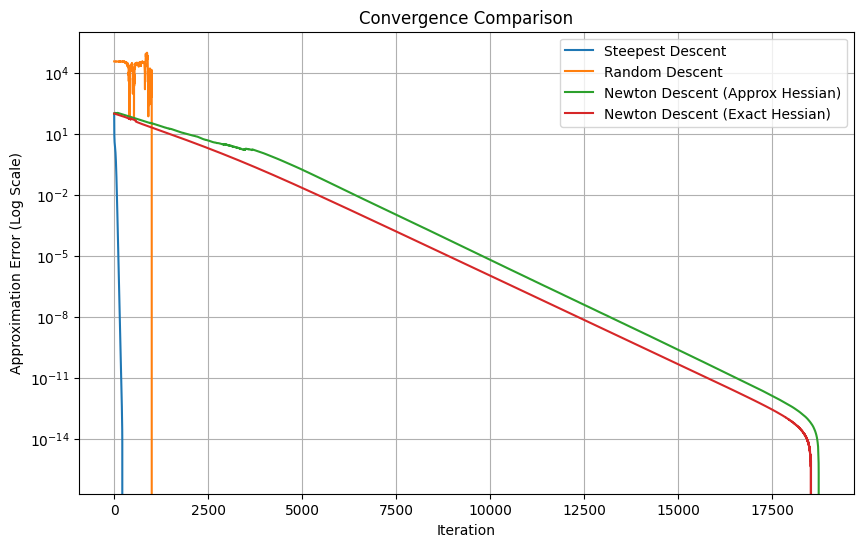

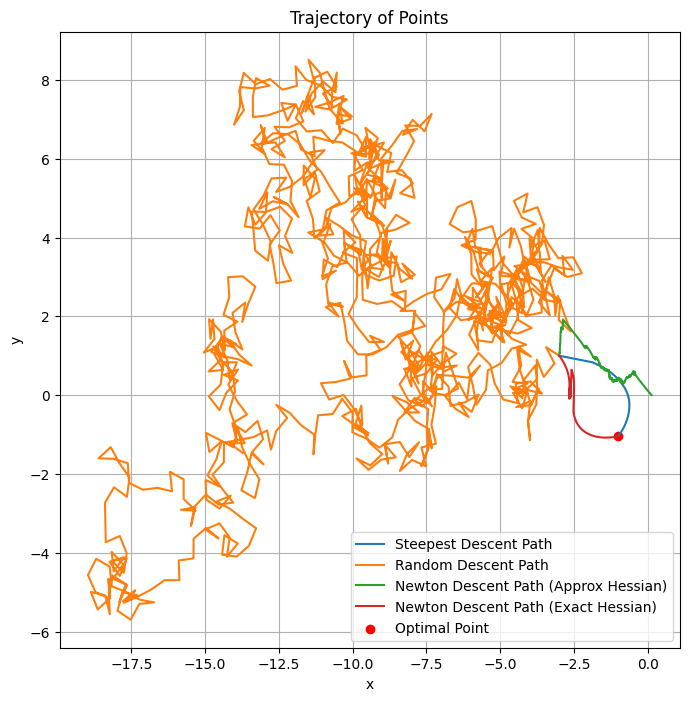

In [14]:
# Plot the error progression for both methods
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(f_values_steep)), np.abs(f_values_steep - f_values_steep[-1]), label="Steepest Descent")
plt.plot(np.arange(len(f_values_random)), np.abs(f_values_random - f_values_random[-1]), label="Random Descent")
plt.plot(np.arange(len(f_values_newton_approx)), np.abs(f_values_newton_approx - f_values_newton_approx[-1]), label="Newton Descent (Approx Hessian)")
plt.plot(np.arange(len(f_values_newton)), np.abs(f_values_newton - f_values_newton[-1]), label="Newton Descent (Exact Hessian)")

plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Approximation Error (Log Scale)')
plt.title('Convergence Comparison')
plt.legend()
plt.grid(True)
plt.show()

# Optional: Plot the path for 2D function visualization
x_seq_steep = np.array(x_sequence_steep)
x_seq_random = np.array(x_sequence_random)
x_seq_newton_approx = np.array(x_sequence_newton_approx)
x_seq_newton = np.array(x_sequence_newton)

plt.figure(figsize=(8, 8))
plt.plot(x_seq_steep[:, 0], x_seq_steep[:, 1], label="Steepest Descent Path")
plt.plot(x_seq_random[:, 0], x_seq_random[:, 1], label="Random Descent Path")
plt.plot(x_seq_newton_approx[:, 0], x_seq_newton_approx[:, 1], label="Newton Descent Path (Approx Hessian)")
plt.plot(x_seq_newton[:, 0], x_seq_newton[:, 1], label="Newton Descent Path (Exact Hessian)")
plt.scatter(x_optimal[0], x_optimal[1], color='red', label="Optimal Point")
plt.xlabel('x')
plt.ylabel('y')
plt.title('Trajectory of Points')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
print("Steepest Converged: ", conv_steep)
print("Random Converged: ", conv_random)
print("Newton Converged (Approx Hessian): ", conv_newton_approx)
print("Newton Converged (Exact Hessian): ", conv_newton)

Steepest Converged:  True
Random Converged:  False
Newton Converged (Approx Hessian):  True
Newton Converged (Exact Hessian):  True


b) La función de Rosenbrock 2-dimensional $ f : \mathbb{R}^2 \rightarrow \mathbb{R} $, dada por

$$
f(x_1, x_2) = 100(x_2 - x_1^2)^2 + (1 - x_1)^2.
$$

Punto inicial: $ x_0 = (-1.2, 1)^T $ 
Óptimo: $ x^* = (1, 1)^T $ 
$ f(x^*) = 0 $


In [16]:
# Shared parameters
def f(x):
    return 100*(x[1] - x[0]**2)**2 + (1 - x[0])**2

x_optimal = np.array([1, 1])

x0 = np.array([-1.2, 1]) # Initial point
alpha = 0.0001 # Learning rate
maxIter = 1000
epsilon = 1e-6

# Calculate the gradient
x,y = sp.symbols('x y')
f_xy  = 100*(y - x**2)**2 + (1 - x)**2
grad_f_xy = [sp.diff(f_xy, var) for var in (x, y)]

print(grad_f_xy)

def grad_f(x):
    df_dx1 = -400*x[0]*(x[1] - x[0]**2) + 2*x[0] - 2
    df_dx2 = 200*(x[1] - x[0]**2)

    # Clip large values to avoid overflow
    df_dx1 = np.clip(df_dx1, -1e6, 1e6)
    df_dx2 = np.clip(df_dx2, -1e6, 1e6)

    return np.array([df_dx1, df_dx2])


def hessian_f(x):
    # https://www.wolframalpha.com/input?i=Hessian+matrix+100%28x-y%5E2%29%5E2%2B%281-x%29%5E2
    hess = np.zeros((2, 2))
    hess[0, 0] = 202
    hess[0, 1] = -400*x[1]
    hess[1, 0] = -400*x[1]
    hess[1, 1] = 800 * x[1]**2 - 400 * (x[0] - x[1] ** 2)
    return hess

[-400*x*(-x**2 + y) + 2*x - 2, -200*x**2 + 200*y]


In [17]:
alpha_steepest = 0.001
maxIter_steepest = 100000
alpha_random = 0.1 # Trial and error! We could use 0.1, 0.01, 0.001, etc.
alpha_newton_approx = 0.001
maxIter_newton_approx = 100000

# Random Direction Descent
x_best_random, f_values_random, x_sequence_random, iter_random, conv_random = naive_gradient_descent_random(
    f, x0, alpha_random, maxIter, epsilon)

# Steepest Descent
x_best_steep, f_values_steep, x_sequence_steep, iter_steep, conv_steep = naive_gradient_descent(
    f, grad_f, x0, alpha_steepest, maxIter, epsilon)

# Newton Descent (Approx Hessian)
x_best_newton_approx, f_values_newton_approx, x_sequence_newton_approx, iter_newton_approx, conv_newton_approx = newton_gradient_descent_approx_hessian(
    f, grad_f, x0, alpha_newton_approx, maxIter_newton_approx, epsilon)

# Newton Descent (Exact Hessian)
x_best_newton, f_values_newton, x_sequence_newton, iter_newton, conv_newton = newton_gradient_descent_exact_hessian(
    f,
    grad_f, # Gradient of the objective function
    hessian_f, # Exact Hessian of the objective function
    x0,
    alpha_newton_approx,
    maxIter_newton_approx,
    epsilon
)

In [18]:
table_steep = create_table(x_sequence_steep, f_values_steep, grad_f)
table_random = create_table(x_sequence_random, f_values_random, grad_f)
table_newton_approx = create_table(x_sequence_newton_approx, f_values_newton_approx, grad_f)
table_newton = create_table(x_sequence_newton, f_values_newton, grad_f)

table_steep

,xk,Approximation Error,Gradient Norm
0,"[-1.2, 1.0]",23.746471,232.867688
1,"[-0.9843999999999999, 1.088]",4.899383,49.030587
2,"[-1.0272715665664, 1.0642086720000001]",3.664261,1.826163
3,"[0.32537140213333743, 0.10277717062240438]",3.661023,1.130893
4,"[0.326318581136839, 0.10339504636316629]",3.657873,1.128327
5,"[0.32726277475284604, 0.10401280036956499]",3.654722,1.125772


In [19]:
table_random

,xk,Approximation Error,Gradient Norm
0,"[-1.2, 1.0]",-140.836978,232.867688
1,"[-1.1215111131223028, 0.9380363442274421]",-150.312109,160.935965
2,"[-1.188569552467309, 0.8638530191967311]",-130.124106,287.124123
3,"[0.1489273055405403, 1.2250699847738726]",-116.557741,251.514303
4,"[0.05213378762493158, 1.250189994517516]",-74.035232,251.050642
5,"[0.13831885665438565, 1.300906203725108]",-28.990210,266.447885


In [20]:
table_newton_approx

,xk,Approximation Error,Gradient Norm
0,"[-1.2, 1.0]",24.200000,2.328677e+02
1,"[-1.1999731219709209, 1.00037549273021]",24.161181,2.326345e+02
2,"[-1.1999728203468194, 1.0008234529600084]",24.121755,2.324011e+02
3,"[0.9999989958279807, 0.9999979886253836]",24.083639,1.000388e-06
4,"[0.9999989968321521, 0.9999979906367561]",24.044339,9.993877e-07
5,"[0.9999989978353193, 0.999997992646117]",24.006328,9.983883e-07


In [21]:
table_newton

,xk,Approximation Error,Gradient Norm
0,"[-1.2, 1.0]",20.310536,232.867688
1,"[-1.1977842997323818, 1.000579928635147]",19.785706,229.443285
2,"[-1.1955996389364365, 1.0011518948076397]",19.275848,226.081285
3,"[-0.9701950953725544, 0.9501102703269895]",18.780486,1.839332
4,"[-0.9701945489719084, 0.9501092109496475]",18.299161,1.839332
5,"[-0.9701940025700032, 0.9501081515704608]",17.831433,1.839333


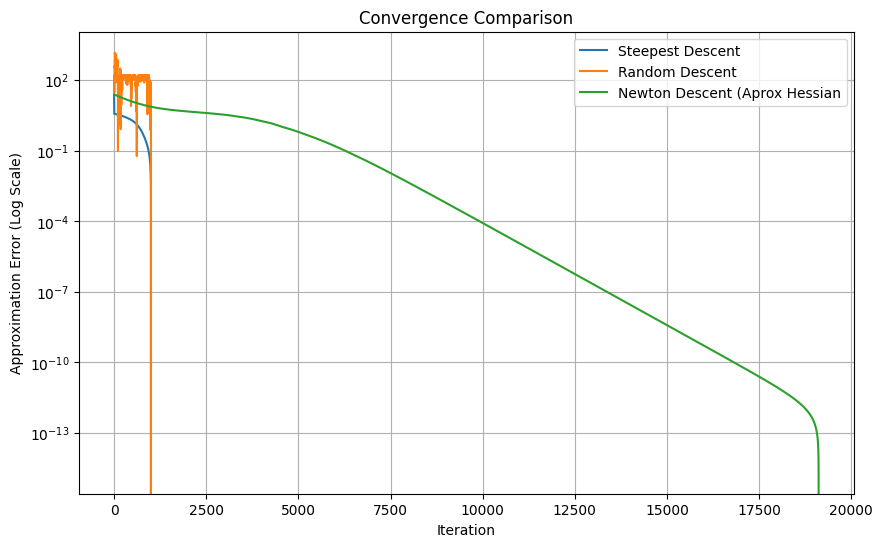

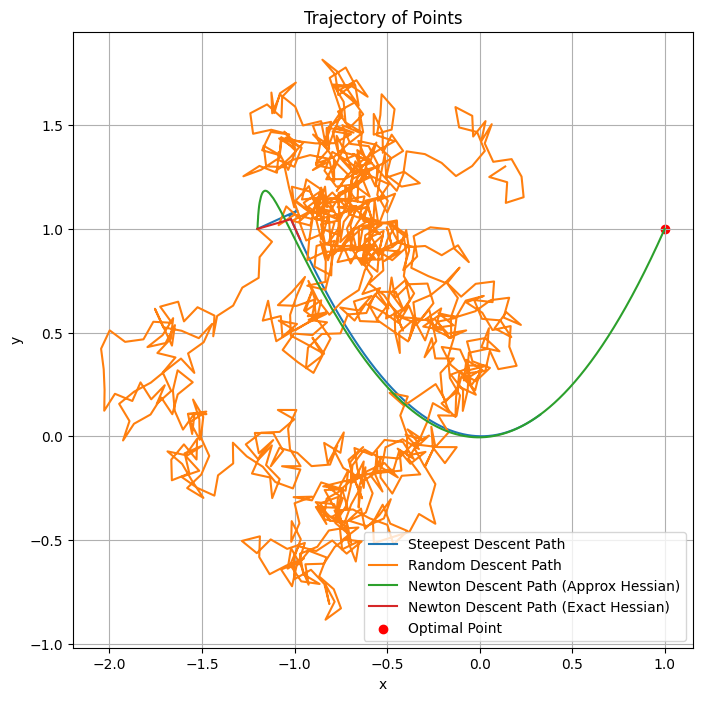

In [22]:
# Plot the error progression for both methods
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(f_values_steep)), np.abs(f_values_steep - f_values_steep[-1]), label="Steepest Descent")
plt.plot(np.arange(len(f_values_random)), np.abs(f_values_random - f_values_random[-1]), label="Random Descent")
plt.plot(np.arange(len(f_values_newton_approx)), np.abs(f_values_newton_approx - f_values_newton_approx[-1]), label="Newton Descent (Aprox Hessian")
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Approximation Error (Log Scale)')
plt.title('Convergence Comparison')
plt.legend()
plt.grid(True)
plt.show()

# Optional: Plot the path for 2D function visualization
x_seq_steep = np.array(x_sequence_steep)
x_seq_random = np.array(x_sequence_random)
x_seq_newton_approx = np.array(x_sequence_newton_approx)
x_seq_newton = np.array(x_sequence_newton)

plt.figure(figsize=(8, 8))
plt.plot(x_seq_steep[:, 0], x_seq_steep[:, 1], label="Steepest Descent Path")
plt.plot(x_seq_random[:, 0], x_seq_random[:, 1], label="Random Descent Path")
plt.plot(x_seq_newton_approx[:, 0], x_seq_newton_approx[:, 1], label="Newton Descent Path (Approx Hessian)")
plt.plot(x_seq_newton[:, 0], x_seq_newton[:, 1], label="Newton Descent Path (Exact Hessian)")
plt.scatter(x_optimal[0], x_optimal[1], color='red', label="Optimal Point")
plt.xlabel('x')
plt.ylabel('y')
plt.title('Trajectory of Points')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
print("Steepest Converged: ", conv_steep)
print("Random Converged: ", conv_random)
print("Newton Converged (Approx Hessian): ", conv_newton_approx)

Steepest Converged:  False
Random Converged:  False
Newton Converged (Approx Hessian):  True


c) La función de Rosenbrock 10-dimensional $ f : \mathbb{R}^{10} \rightarrow \mathbb{R} $, dada por

$$
f(x) = \sum_{i=1}^{9} 100(x_{i+1} - x_i^2)^2 + (1 - x_i)^2.
$$

Punto inicial: $ x_0 = (-1.2, 1, 1, \dots, 1, -1.2, 1)^T $ 
Óptimo: $ x^* = (1, 1, \dots, 1)^T $ 
$ f(x^*) = 0 $


In [24]:
import numpy as np
import sympy as sp
from sympy import lambdify

def f(x):
    return sum(100*(x[i+1] - x[i]**2)**2 + (1 - x[i])**2 for i in range(len(x) - 1))

x_optimal = np.ones(10)
x0 = np.array([-1.2] + [1]*8 + [-1.2])

alpha = 0.0001
maxIter = 1000
epsilon = 1e-6


n = 10
x_symbols = sp.symbols(f'x1:{n+1}')  # x1, x2, ..., x10

# f(x)
f_xy = sum(100*(x_symbols[i+1] - x_symbols[i]**2)**2 + (1 - x_symbols[i])**2 for i in range(n - 1))

# Gradient of f(x)
grad_f_xy = [sp.diff(f_xy, x_symbols[i]) for i in range(n)]


print(grad_f_xy) # use this as reference for grad_f


def grad_f(x):
    n = len(x)
    grad = np.zeros(n)

    for i in range(n - 1):
        # Gradients for all indices except the last
        grad[i] = -400 * x[i] * (x[i+1] - x[i]**2) + 2 * (x[i] - 1)

    for i in range(1, n):
        # Add terms involving the next variable for indices 2 to n-1
        grad[i] += 200 * (x[i] - x[i-1]**2)

    # Clip large values to avoid overflow
    grad = np.clip(grad, -1e6, 1e6)

    return grad

def hessian_f(x):
    """
    Calcula la matriz Hessiana para la función de Rosenbrock de 10 dimensiones.

    Parámetros:
    x (numpy.ndarray): Vector de entrada de 10 dimensiones.

    Retorna:
    numpy.ndarray: Matriz Hessiana de 10x10.
    """
    n = len(x)
    H = np.zeros((n, n))

    for i in range(n):
        if i < n - 1:
            # Diagonal principal
            H[i, i] += 1200 * x[i]**2 - 400 * x[i + 1] + 2
            if i > 0:
                # Contribución adicional de 200 para i = 1 a 8
                H[i, i] += 200
            # Elementos fuera de la diagonal
            H[i, i + 1] += -400 * x[i]
            H[i + 1, i] += -400 * x[i]
        else:
            # Última diagonal principal (i = 9)
            H[i, i] += 200

    return H

# This next part is to see if we defined the gradient correctly
grad_at_x0 = grad_f(x0)
grad_f_numeric = [lambdify(x_symbols, grad_f_xy[i], "numpy") for i in range(len(grad_f_xy))]
x0 = np.array([-1.2] + [1]*8 + [-1.2])
grad_f_symbolic_at_x0 = np.array([grad(*x0) for grad in grad_f_numeric])

print(f"Symbolic Gradient at x0: {grad_f_symbolic_at_x0}")
print(f"Numeric Gradient at x0: {grad_at_x0}")

[-400*x1*(-x1**2 + x2) + 2*x1 - 2, -200*x1**2 - 400*x2*(-x2**2 + x3) + 202*x2 - 2, -200*x2**2 - 400*x3*(-x3**2 + x4) + 202*x3 - 2, -200*x3**2 - 400*x4*(-x4**2 + x5) + 202*x4 - 2, -200*x4**2 - 400*x5*(-x5**2 + x6) + 202*x5 - 2, -200*x5**2 - 400*x6*(-x6**2 + x7) + 202*x6 - 2, -200*x6**2 - 400*x7*(-x7**2 + x8) + 202*x7 - 2, -200*x7**2 - 400*x8*(-x8**2 + x9) + 202*x8 - 2, -200*x8**2 - 400*x9*(x10 - x9**2) + 202*x9 - 2, 200*x10 - 200*x9**2]
Symbolic Gradient at x0: [-215.6  -88.     0.     0.     0.     0.     0.     0.   880.  -440. ]
Numeric Gradient at x0: [-215.6  -88.     0.     0.     0.     0.     0.     0.   880.  -440. ]


In [25]:
def symbolic_hessian_rosenbrock_10d():
    n = 10
    x = sp.symbols(f'x1:{n+1}')  # x1, x2, ..., x10

    # Definir la función de Rosenbrock de 10 dimensiones
    f = sum(100*(x[i+1] - x[i]**2)**2 + (1 - x[i])**2 for i in range(n-1))

    # Calcular la matriz Hessiana simbólicamente
    H = sp.hessian(f, x)

    return H, x

# Obtener la matriz Hessiana simbólica y los símbolos
H_sym, symbols = symbolic_hessian_rosenbrock_10d()

# Convertir la matriz Hessiana simbólica a funciones numéricas
H_func = sp.lambdify(symbols, H_sym, 'numpy')

# Evaluar la Hessiana en un punto específico
x0 = np.array([-1.2, 1, 1, 1, 1, 1, 1, 1, -1.2, 1])
H_numeric = H_func(*x0)

print("Matriz Hessiana simbólica evaluada en x0:")
print(H_numeric)

# Comparar con la implementación manual
H_manual = hessian_f(x0)
print("Matriz Hessiana manual en x0:")
print(H_manual)

# Verificar si son iguales
print("¿Las matrices Hessianas coinciden?", np.allclose(H_numeric, H_manual))

Matriz Hessiana simbólica evaluada en x0:
[[1330.  480.    0.    0.    0.    0.    0.    0.    0.    0.]
 [ 480. 1002. -400.    0.    0.    0.    0.    0.    0.    0.]
 [   0. -400. 1002. -400.    0.    0.    0.    0.    0.    0.]
 [   0.    0. -400. 1002. -400.    0.    0.    0.    0.    0.]
 [   0.    0.    0. -400. 1002. -400.    0.    0.    0.    0.]
 [   0.    0.    0.    0. -400. 1002. -400.    0.    0.    0.]
 [   0.    0.    0.    0.    0. -400. 1002. -400.    0.    0.]
 [   0.    0.    0.    0.    0.    0. -400. 1882. -400.    0.]
 [   0.    0.    0.    0.    0.    0.    0. -400. 1530.  480.]
 [   0.    0.    0.    0.    0.    0.    0.    0.  480.  200.]]
Matriz Hessiana manual en x0:
[[1330.  480.    0.    0.    0.    0.    0.    0.    0.    0.]
 [ 480. 1002. -400.    0.    0.    0.    0.    0.    0.    0.]
 [   0. -400. 1002. -400.    0.    0.    0.    0.    0.    0.]
 [   0.    0. -400. 1002. -400.    0.    0.    0.    0.    0.]
 [   0.    0.    0. -400. 1002. -400.    0.  

In [26]:
alpha_steepest = 0.001
maxIter_steepest = 10000
alpha_random = 0.1 # Trial and error! We could use 0.1, 0.01, 0.001, etc.
alpha_newton_approx = 0.005
maxIter_newton_approx = 1000

# Random Direction Descent
x_best_random, f_values_random, x_sequence_random, iter_random, conv_random = naive_gradient_descent_random(
    f, x0, alpha_random, maxIter, epsilon)

# Steepest Descent
x_best_steep, f_values_steep, x_sequence_steep, iter_steep, conv_steep = naive_gradient_descent(
    f, grad_f, x0, alpha_steepest, maxIter, epsilon)

# Newton Descent (Approx Hessian)
x_best_newton_approx, f_values_newton_approx, x_sequence_newton_approx, iter_newton_approx, conv_newton_approx = newton_gradient_descent_approx_hessian(
    f, grad_f, x0, alpha_newton_approx, maxIter_newton_approx, epsilon)

# Newton Descent (Exact Hessian)
x_best_newton, f_values_newton, x_sequence_newton, iter_newton, conv_newton = newton_gradient_descent_exact_hessian(
    f,
    grad_f, # Gradient of the objective function
    hessian_f, # Exact Hessian of the objective function
    x0,
    alpha_newton_approx,
    maxIter_newton_approx,
    epsilon
)

In [27]:
table_steep = create_table(x_sequence_steep, f_values_steep, grad_f)
table_random = create_table(x_sequence_random, f_values_random, grad_f)
table_newton_approx = create_table(x_sequence_newton_approx, f_values_newton_approx, grad_f)
table_newton = create_table(x_sequence_newton, f_values_newton, grad_f)

table_steep

,xk,Approximation Error,Gradient Norm
0,"[-1.2, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.2...",528.267319,1125.247848
1,"[-0.9843999999999999, 1.088, 1.0, 1.0, 1.0, 1....",179.097066,434.803485
2,"[-1.0272715665664, 0.9840672831999999, 1.03674...",97.141788,201.378854
3,"[-0.9917124690054239, 0.9935396115972839, 0.99...",74.978050,0.514986
4,"[-0.991714137651214, 0.9935429051788628, 0.992...",62.713611,0.514383
5,"[-0.9917158032962525, 0.9935461928508638, 0.99...",53.393471,0.513781


In [28]:
table_random

,xk,Approximation Error,Gradient Norm
0,"[-1.2, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.2...",-5982.652529,1125.247848
1,"[-1.2083047954634256, 0.9867888224039322, 1.00...",-5924.485802,1230.988649
2,"[-1.153012754389938, 0.9222094551841379, 0.999...",-5952.134518,1185.166035
3,"[-1.6628118575722313, 1.0458964951005691, 1.34...",-5917.817994,6921.838394
4,"[-1.6444629833343283, 1.011157391690958, 1.363...",-5892.341776,7114.192100
5,"[-1.6230198589817457, 1.0037757498109066, 1.41...",-5900.470210,7186.741958


In [29]:
table_newton_approx

,xk,Approximation Error,Gradient Norm
0,"[-1.2, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.2...",528.306728,1125.247848
1,"[-1.1991901766116118, 1.0000568549133528, 0.99...",525.249979,1119.494750
2,"[-1.198385789897648, 1.0002591494143434, 1.000...",521.979886,1114.061754
3,"[-0.9942643118793165, 0.9949234478224911, 0.99...",517.535752,6.896744
4,"[-0.9942554381718185, 0.9949241996559803, 0.99...",514.538479,6.862437
5,"[-0.9942477505387476, 0.9949271296742696, 0.99...",512.045368,6.827876


In [30]:
table_newton

,xk,Approximation Error,Gradient Norm
0,"[-1.2, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.2...",528.115371,1125.247848
1,"[-1.1992100631336537, 1.0000570499328323, 0.99...",524.476945,1119.633814
2,"[-1.1984224347420864, 1.0001130828055909, 0.99...",520.860786,1114.047787
3,"[-0.993184719209308, 0.9927978621150955, 0.990...",517.266768,7.579454
4,"[-0.9931797314829139, 0.9928062232610033, 0.99...",513.694769,7.541529
5,"[-0.9931747961849116, 0.99281459739963, 0.9903...",510.144666,7.503794


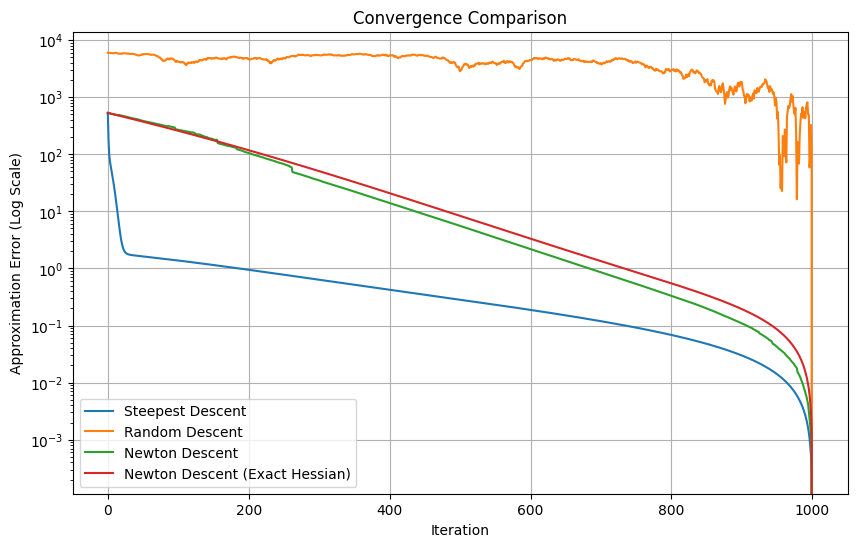

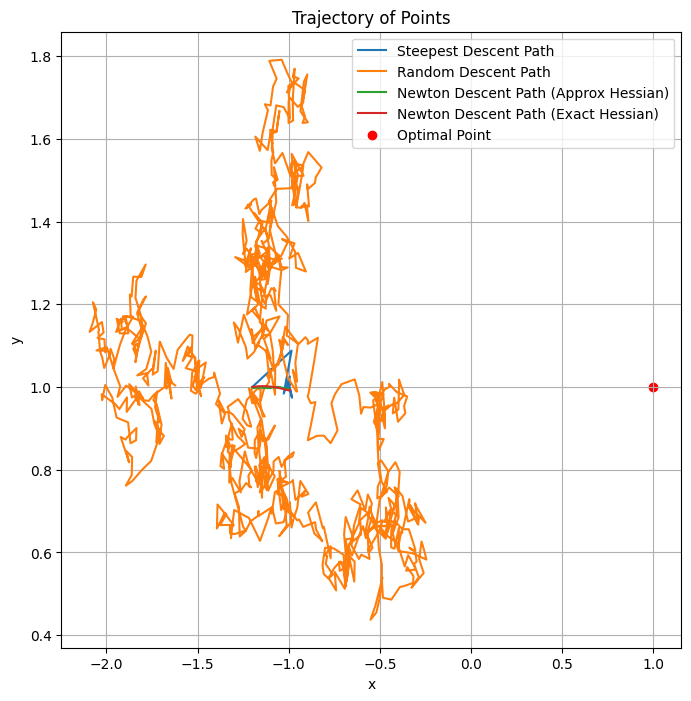

Steepest Converged:  False
Random Converged:  False
Newton Converged (Approx Hessian):  False
Newton Converged (Exact Hessian):  False


In [31]:
# Plot the error progression for both methods
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(f_values_steep)), np.abs(f_values_steep - f_values_steep[-1]), label="Steepest Descent")
plt.plot(np.arange(len(f_values_random)), np.abs(f_values_random - f_values_random[-1]), label="Random Descent")
plt.plot(np.arange(len(f_values_newton_approx)), np.abs(f_values_newton_approx - f_values_newton_approx[-1]), label="Newton Descent")
plt.plot(np.arange(len(f_values_newton)), np.abs(f_values_newton - f_values_newton[-1]), label="Newton Descent (Exact Hessian)")
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Approximation Error (Log Scale)')
plt.title('Convergence Comparison')
plt.legend()
plt.grid(True)
plt.show()

# Optional: Plot the path for 2D function visualization
x_seq_steep = np.array(x_sequence_steep)
x_seq_random = np.array(x_sequence_random)
x_seq_newton_approx = np.array(x_sequence_newton_approx)
x_seq_newton = np.array(x_sequence_newton)

plt.figure(figsize=(8, 8))
plt.plot(x_seq_steep[:, 0], x_seq_steep[:, 1], label="Steepest Descent Path")
plt.plot(x_seq_random[:, 0], x_seq_random[:, 1], label="Random Descent Path")
plt.plot(x_seq_newton_approx[:, 0], x_seq_newton_approx[:, 1], label="Newton Descent Path (Approx Hessian)")
plt.plot(x_seq_newton[:, 0], x_seq_newton[:, 1], label="Newton Descent Path (Exact Hessian)")
plt.scatter(x_optimal[0], x_optimal[1], color='red', label="Optimal Point")
plt.xlabel('x')
plt.ylabel('y')
plt.title('Trajectory of Points')
plt.legend()
plt.grid(True)
plt.show()

print("Steepest Converged: ", conv_steep)
print("Random Converged: ", conv_random)
print("Newton Converged (Approx Hessian): ", conv_newton_approx)
print("Newton Converged (Exact Hessian): ", conv_newton)